## GEI723, Université de Sherbrooke, 5 Novembre 2021. Jean Rouat
## Cours gradué en génie neurocomputationnel de la faculté de génie

Ce notebook est une adaptation de la classification par STDP de MNIST par Diehl & Cook, créé par I. Balafrej pour l'automne 2019, et adapté par A. El Ferdaoussi pour l'automne 2020.

L'article de Diehl & Cook est disponible ici: https://www.frontiersin.org/articles/10.3389/fncom.2015.00099/full

Le modèle est simplifié un peu et réécrit pour Brian2 et Python 3. Le code est à trous, et les parties à compléter sont indiquées par 'COMPLETER'.

ATTENTION: Dans l'exemple donné ici les auteurs utilisent seulement des données d'entrainement et de validation. Ils utilisent à tort le mot "test" pour désigner les données de validation.

Les équations et certains paramètres des neurones sont fournies.

Un exemple d'encodage par fréquence est utilisé (voir la partie "testons à présent le réseau entrainé'). Vous avez toute liberté d'utiliser un autre type d'encodage.

#### ATTENTION: Ce code est fourni à titre d'exemple. Vous n'avez aucune obligation de résoudre votre problème spécifiquement avec ce code.

In [18]:
import numpy as np
from sklearn import datasets, model_selection
from brian2 import *
import matplotlib.pyplot as plt
%matplotlib inline
codegen.target = 'cython'

## Ensemble de données MNIST

On télécharge l'ensemble de données MNIST directement dans le code. MNIST est disponible à https://www.openml.org/d/554

L'argument 'data_home' peut être utilisé pour télécharger MNIST dans un répertoire de votre choix. (Le répertoire par défaut est '~/scikit_learn_data/'.)

In [19]:
X_all, y_all = datasets.fetch_openml('mnist_784', version=1, return_X_y=True, data_home=None)

MNIST est constituté de 70k d'images de 28x28 pixels, de chiffres.

'X' est le vecteur d'images, et 'y' est le vecteur d'étiquettes (labels).

La simulation avec toutes les images est assez longue à faire rouler. Utilisons uniquement un sous-ensemble de MNIST pour une simulation plus rapide.

In [20]:
subset=100
test_size=int(subset/5)
X = X_all[:subset]
y = y_all[:subset]

Divisons MNIST en ensembles d'entrainement et de test pour entrainer et tester le modèle post-apprentissage.

Si on travaille avec l'ensemble au complet, on peut prendre 10k pour le test par exemple.

In [21]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=test_size)

Dessinons une image aléatoire de l'ensemble de données pour voir ce à quoi ressemble MNIST.

Les images dans MNIST sont des vecteurs. Il faut donc les ré-organiser en matrice 28x28 pour les afficher.

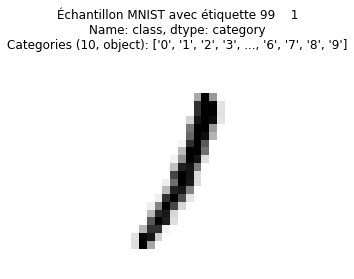

In [22]:
index = np.random.randint(0, len(X_train)-1)


plt.figure()
plt.axis('off')
original_img=X_train[index:index+1].values.reshape(28, 28)
plt.imshow(original_img, cmap=plt.cm.gray_r)
plt.title("Échantillon MNIST avec étiquette %s" % y_train[index:index+1]);

## Réseau de neurones Brian2

On peut maintenant créer un réseau Brian2. Commençons par définir quelques paramètres.

In [23]:
# Fixons le seed aléatoire afin de pouvoir reproduire les résultats
np.random.seed(0)

# Horloge de Brian2
defaultclock.dt = 0.5 * units.ms

# Cible de génération de code pour Brian2
prefs.codegen.target = 'cython'

time_per_sample =   0.35 * units.second
resting_time = 0.15 * units.second

v_rest_e = -65. * units.mV 
v_rest_i = -60. * units.mV 

v_reset_e = -65. * units.mV
v_reset_i = -45. * units.mV

v_thresh_e = -52. * units.mV
v_thresh_i = -40. * units.mV

refrac_e = 5. * units.ms
refrac_i = 2. * units.ms

tc_theta = 1e7 * units.ms
theta_plus_e = 0.05 * units.mV

tc_pre_ee = 20 * units.ms
tc_post_1_ee = 20 * units.ms
tc_post_2_ee = 40 * units.ms

# Taux d'apprentissage
nu_ee_pre =  0.0001
nu_ee_post = 0.01

Ne=400
Ni=Ne

wmax_ee = 1.0

delay={}
delay['ee_input'] = (0*ms,10*ms)
delay['ei_input'] = (0*ms,5*ms)
input_intensity = 2.
offset = 20.0*mV

Définissons l'entrée au réseau de neurones. L'entrée est un encodeur de type codage par COMPLETER.

In [24]:
def encode_h_poisson(stimulus, window):
    """
    Encodage en taux de décharge d'un stimulus statique avec processus homogène de Poisson
    
    Args:
        stimulus : le stimulus à encoder
        window   : fenêtre temporelle en ms (avec pas discrets de 1 ms)
  
    Returns:
        spikes   : trains de décharges
    """
    
    spikes = np.zeros((stimulus.size, window))

    for n in range(stimulus.size):
        # Générer aléatoirement des décharges en fonction de la valeur d'intensité des pixels
        mask = np.random.rand(window) < stimulus[n]
        spikes[n, mask] = 1
    return spikes

def decode_h_poisson(spikes, window):
    """
    Décodage d'un stimulus statique à partir du taux de décharge pour un encodage avec processus homogène de Poisson.
    
    Args:
        spikes : trains de décharges
        window : fenêtre temporelle en ms (avec pas discrets de 1 ms)
  
    Returns:
        decoded_stimulus : stimulus décodé (reconstruit) à partir des trains de décharges
    """

    # Calculer le nombre de décharge pour chaque neurone
    spike_count = np.sum(spikes, axis=1)

    # Convertir le nombre de décharges en valeur d'intensité de pixel décodée
    decoded_stimulus = spike_count / window

    return decoded_stimulus


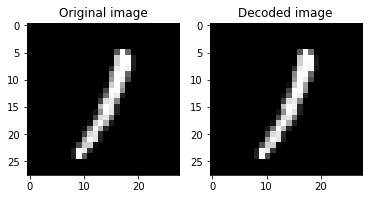

In [25]:

# Choisir la taille de la fenêtre temporelle d'encodage
window = 350  # en ms
img=X_train[index:index+1].values.reshape(784) /255

# Encoder le stimulus
spikes = encode_h_poisson(img, window)

# Reconstruire l'image
decoded_stimulus = decode_h_poisson(spikes, window)

# Redimensionner le vecteur en image 2D
decoded_img = np.reshape(decoded_stimulus, (28, 28))

# Afficher l'image originale et l'image reconstruite
fig, axes = plt.subplots(1, 2)
axes[0].imshow(original_img, cmap='gray')
axes[0].set_title('Original image')
axes[1].imshow(decoded_img, cmap='gray')
_ = axes[1].set_title('Decoded image')

In [26]:

input_group = PoissonGroup(X_train.shape[1],0*Hz)


Définissons notre modèle de neurone ainsi que nos groupes de neurones.

In [27]:
neuron_eqs_e = '''
    dv/dt = ((v_rest_e - v) + (I_synE + I_synI) / nS) / tau  : volt (unless refractory)

    I_synE =  ge * nS * -v           : amp
    
    I_synI =  gi * nS * (d_I_synI-v) : amp
    
    dge/dt = -ge/(1.0*ms)            : 1
    
    dgi/dt = -gi/(2.0*ms)            : 1
    
    tau                              : second (constant, shared)
    
    d_I_synI                         : volt (constant, shared)
    
    dtheta/dt = -theta / (tc_theta)  : volt
    
    
'''

neuron_eqs_i = '''
        dv/dt = ((v_rest_i - v) + (I_synE+I_synI) / nS) / (10*ms)  : volt
        I_synE = ge * nS *         -v                           : amp
        I_synI = gi * nS * (-85.*mV-v)                          : amp
        dge/dt = -ge/(1.0*ms)                                   : 1
        dgi/dt = -gi/(2.0*ms)                                  : 1
        '''


excitatory_group = NeuronGroup(
    N=Ne, model=neuron_eqs_e, refractory=refrac_e, 
    threshold='v>v_thresh_e+ theta - 20.0*mV', reset='v=v_rest_e; theta += theta_plus_e;', method='euler')
excitatory_group.tau = 100 * units.ms
excitatory_group.d_I_synI = -100. * units.mV
excitatory_group.v=v_rest_e - 40. * mV
excitatory_group.theta=np.ones((Ne)) * 20.0*mV

inhibitory_group = NeuronGroup(
    N=Ni, model=neuron_eqs_i, refractory=refrac_i, 
    threshold='v>v_thresh_i', reset='v=v_rest_i', method='euler')
inhibitory_group.v=v_rest_i - 40. * mV

In [28]:
print(refrac_e)

5. ms


Et les synapses.

In [29]:
synapse_model = "w : 1"

stdp_synapse_model = '''
    w : 1

    plastic : boolean (shared) # Activer/désactiver la plasticité
    
    post2before : 1
    
    dpre/dt   =   -pre/(tc_pre_ee) : 1 (event-driven)
    
    dpost1/dt  =  -post1/(tc_post_1_ee) : 1 (event-driven)
    
    dpost2/dt  =  -post2/(tc_post_2_ee) : 1 (event-driven)
'''

stdp_pre = '''
    ge_post += w
    
    pre = 1.
    
    w = clip(w - nu_ee_pre * post1*plastic, 0, wmax_ee)
'''

stdp_post = '''
    post2before = post2
    
    w = clip(w + nu_ee_post * pre * post2before*plastic, 0, wmax_ee)
    
    post1 = 1.
    
    post2 = 1.
'''

input_synapse = Synapses(input_group,excitatory_group,model=stdp_synapse_model, on_pre=stdp_pre, on_post=stdp_post)
input_synapse.connect(True) # Fully connected
deltaDelay=delay['ee_input'][0] - delay['ee_input'][1]
input_synapse.delay = 'deltaDelay*rand() '
input_synapse.plastic = True
input_synapse.w = '(rand()+0.1)*0.3'

#e_i_synapse = Synapses(excitatory_group, inhibitory_group, model=stdp_synapse_model, on_pre=stdp_pre, on_post=stdp_post)
e_i_synapse = Synapses(excitatory_group, inhibitory_group, model=synapse_model, on_pre="ge_post += w")
e_i_synapse.connect(True, p=0.0025)
e_i_synapse.w = 'rand()*10.4'

i_e_synapse = Synapses(inhibitory_group, excitatory_group, model=synapse_model, on_pre="gi_post += w")
i_e_synapse.connect(True, p=0.9)
i_e_synapse.w = 'rand()*17.0'

Combien de synapses a-t-on dans le réseau?

In [30]:
print(len(input_synapse) + len(e_i_synapse) + len(i_e_synapse))

457909


Définissons un 'readout' pour notre réseau.

In [31]:
e_monitor = SpikeMonitor(excitatory_group, record=False)

Créons le réseau.

In [32]:
net = Network(input_group, excitatory_group, inhibitory_group, 
              input_synapse, e_i_synapse, i_e_synapse, e_monitor)

## Entrainement

Entrainons à présent notre réseau.

Créons une matrice 'spikes' pour assigner les étiquettes des classes post-apprentissage. Cette matrice accumulera le décompte de décharges par classe.

Notre readout 'e_monitor' est actif tout le long de la simulation avec toutes les images. Donc à chaque nouvelle présentation d'image, on doit soustraire l'ancien décompte de décharges. On utilisera le vecteur 'old_spike_counts' pour le faire. 

In [33]:
spikes = np.zeros((10, len(excitatory_group)))
old_spike_counts = np.zeros(len(excitatory_group))

# Entrainement
number_of_epochs = 1
mean_of_w=[]
j=0
j_max=len(X_train)
for i in range(number_of_epochs):
    print('Starting iteration %i' % i)
    while j < j_max:
        sample=X_train.values[j]
        label=y_train.values[j]
        
        if (j % 10) == 0:
            print("Running sample %i out of %i with input_intensity %i" % (j, len(X_train),input_intensity))
        
        
        # Normaliser les poids
        weight_matrix = np.zeros((784,400))
        weight_matrix[input_synapse.i, input_synapse.j] = input_synapse.w
        colSums = np.sum(weight_matrix, axis = 0)
        colFactors = 78/colSums
        for k in range(Ne):
            weight_matrix[:,k] *= colFactors[k]
        input_synapse.w = weight_matrix[input_synapse.i, input_synapse.j]
        
        input_group.rates = sample / 8.*input_intensity * units.Hz 
        
        net.run(time_per_sample)
        
        current_spike_count = e_monitor.count - old_spike_counts
        old_spike_counts = np.copy(e_monitor.count)
        
        input_group.rates = 0 * units.Hz
        
        
        if np.sum(current_spike_count) < 5:
            input_intensity += 1
            net.run(resting_time)
        else:
            print('For j =',j,'input_intensity=',input_intensity)
            spikes[int(label)] += e_monitor.count - old_spike_counts
            net.run(resting_time)
            input_intensity =2.
            mean_of_w.append(np.mean(input_synapse.w))
            
            
            j+=1
        
        

Starting iteration 0
Running sample 0 out of 80 with input_intensity 2
Running sample 0 out of 80 with input_intensity 3
Running sample 0 out of 80 with input_intensity 4
Running sample 0 out of 80 with input_intensity 5
Running sample 0 out of 80 with input_intensity 6
Running sample 0 out of 80 with input_intensity 7
Running sample 0 out of 80 with input_intensity 8
For j = 0 input_intensity= 8.0
For j = 1 input_intensity= 11.0
For j = 2 input_intensity= 10.0
For j = 3 input_intensity= 7.0
For j = 4 input_intensity= 11.0
For j = 5 input_intensity= 14.0
For j = 6 input_intensity= 15.0
For j = 7 input_intensity= 15.0
For j = 8 input_intensity= 7.0
For j = 9 input_intensity= 18.0
Running sample 10 out of 80 with input_intensity 2
Running sample 10 out of 80 with input_intensity 3
Running sample 10 out of 80 with input_intensity 4
Running sample 10 out of 80 with input_intensity 5
Running sample 10 out of 80 with input_intensity 6
Running sample 10 out of 80 with input_intensity 7
Runnin

(array([ 1345., 16905., 17210., 17293., 17170., 17462., 17232., 17246.,
        17286., 17278., 17425., 17373., 17310., 17208., 17356., 17570.,
        17451., 17488., 15435.,  2557.]),
 array([0.00814824, 0.01727275, 0.02639726, 0.03552177, 0.04464628,
        0.05377079, 0.0628953 , 0.07201981, 0.08114432, 0.09026883,
        0.09939334, 0.10851785, 0.11764236, 0.12676687, 0.13589138,
        0.14501589, 0.1541404 , 0.16326491, 0.17238942, 0.18151393,
        0.19063844]),
 <BarContainer object of 20 artists>)

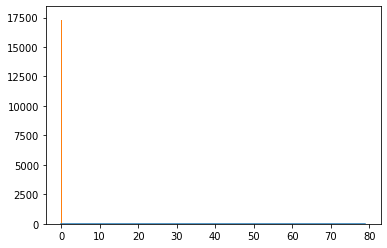

In [34]:
plot(mean_of_w)
hist(input_synapse.w , 20)

## Test

Commençons par trouver le meilleur neurone pour chaque classe de MNIST.

In [35]:
labeled_neurons = np.argmax(spikes, axis=1)

labeled_neurons

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Testons à présent le réseau entrainé!

In [36]:
# Déasctiver la plasticité STDP
input_synapse.plastic = False

num_correct_output = 0

for i, (sample, label) in enumerate(zip(X_test.values, y_test)):
    # Afficher régulièrement l'état d'avancement
    if (i % 10) == 0:
        print("Running sample %i out of %i" % (i, len(X_test)))
    
    # Configurer le taux d'entrée
    # ATTENTION, vous pouvez utiliser un autre type d'encodage
    input_group.rates = sample  / 8.*input_intensity * units.Hz 
    
    # Simuler le réseau
    net.run(time_per_sample)
    
    # Calculer le nombre de décharges pour l'échantillon
    current_spike_count = e_monitor.count - old_spike_counts
    # Gardons une copie du décompte de décharges pour pouvoir calculer le prochain
    old_spike_counts = np.copy(e_monitor.count)
    
    # Prédire la classe de l'échantillon
    output_label = np.argmax(current_spike_count)
    
    # Si la prédiction est correcte
    if output_label == int(label):
        num_correct_output += 1
        
    # Laisser les variables retourner à leurs valeurs de repos
    net.run(resting_time)

    
print("The model accuracy is : %.3f" % (num_correct_output / len(X_test)))    

Running sample 0 out of 20
Running sample 10 out of 20
The model accuracy is : 0.150


In [37]:
y_train.values[0]

'0'

In [38]:
len(X_train)

80

(array([ 1345., 16905., 17210., 17293., 17170., 17462., 17232., 17246.,
        17286., 17278., 17425., 17373., 17310., 17208., 17356., 17570.,
        17451., 17488., 15435.,  2557.]),
 array([0.00814824, 0.01727275, 0.02639726, 0.03552177, 0.04464628,
        0.05377079, 0.0628953 , 0.07201981, 0.08114432, 0.09026883,
        0.09939334, 0.10851785, 0.11764236, 0.12676687, 0.13589138,
        0.14501589, 0.1541404 , 0.16326491, 0.17238942, 0.18151393,
        0.19063844]),
 <BarContainer object of 20 artists>)

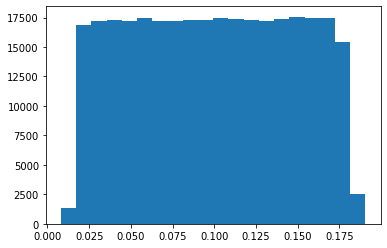

In [39]:
hist(input_synapse.w , 20)